# Analysis of the Osteoathritis Dataset with Pytorch and Fastai
Nikolas Wilhelm

<img src="./img/fastai.png" width="200">
<img src="./img/pytorch.png" width="200">
<img src="./img/osteo.jpg" width="200">

fastai:
https://www.fast.ai/

Pytorch:
https://pytorch.org/

Knee Osteoarthritis Severity Grading Dataset:
http://dx.doi.org/10.17632/56rmx5bjcr.1

## Import the relevant Libraries and Functions

In [1]:
import torch # Pytorch
from fastai.vision import * # The complete Fastai library
from fastai.metrics import error_rate # For Determining the accuracy

## Determine the (personal) path to the dataset

In [2]:
path = 'C:/Users/ga46yeg/data/KneeXrayData/ClsKLData/kneeKL224'

# 1. Create the Databunch
## Databunch contains training, validation and (optional) test sets.
They often come from a general folder:

In [3]:
data = ImageList.from_folder(path)

They require a "training" and "validation" set:

In [4]:
data = data.split_by_folder(valid='val')

They need to have labelsin order to perform classification tasks:

In [5]:
data = data.label_from_folder()

In order to generalise and be compatible the pictures will be transformed:
-tfms contains:
- Flip horicontally (left/right knee)

<img src="./img/flip.jpg" width = 50>

- Rotate by +/- 10 degrees

<img src="./img/rotate.png" width = 50>

- scale by 0.9 until 1.1

<img src="./img/scale.png" width = 50>

In [6]:
tfms = get_transforms()
data = data.transform(tfms)

The Lists are Transformed to the "databunch" class in order to be compatible for training

In [7]:
data = data.databunch()

The input will be normalized in order to improve performance.
As we will be using a "transfer learning" approach the normalization of the original dataset is used.

In [8]:
data = data.normalize(imagenet_stats)

Let's see the current state of our data

In [9]:
data

ImageDataBunch;

Train: LabelList (5778 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: C:\Users\ga46yeg\data\KneeXrayData\ClsKLData\kneeKL224;

Valid: LabelList (826 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: C:\Users\ga46yeg\data\KneeXrayData\ClsKLData\kneeKL224;

Test: None

### Summarize the Creation of the DataBunch

In [10]:
tfms = get_transforms()
data = (
    ImageList.from_folder(path)
    .split_by_folder(valid='val')
    .label_from_folder()
    .transform(tfms)
    .databunch()
    .normalize(imagenet_stats)
)

### Visualize a batch:

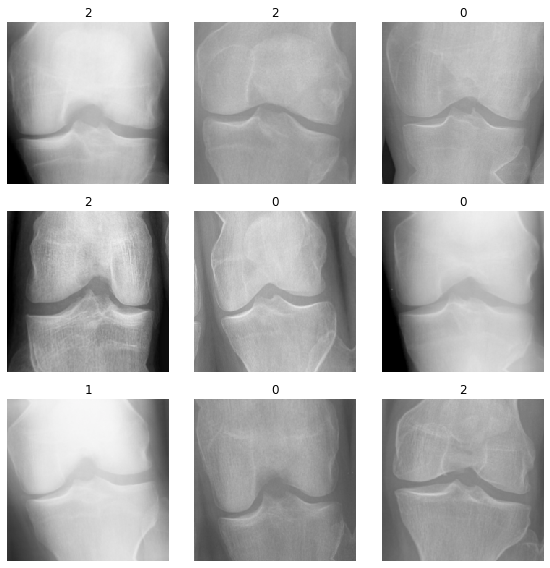

In [11]:
data.show_batch(rows=3, figsize=(8,8))

# 2. Now it is time to define a Neural Network to Generate a "Learner"

### But which kind of network will be taken for Images?

<img src="./img/conv_nn.jpeg">

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

<img src="./img/resnet34.png">

epoch,train_loss,valid_loss,error_rate,time
0,2.312407,1.651278,0.618644,01:02
1,1.899024,1.407487,0.558111,00:54
2,1.532243,1.288769,0.525424,00:54
3,1.367509,1.286781,0.512107,00:54
4,1.290254,1.185230,0.515738,00:54
5,1.220884,1.149442,0.480630,00:54
6,1.170039,1.160689,0.490315,00:54
7,1.162711,1.116327,0.483051,00:54
8,1.120052,1.119402,0.485472,00:54
9,1.114874,1.100892,0.476998,00:54


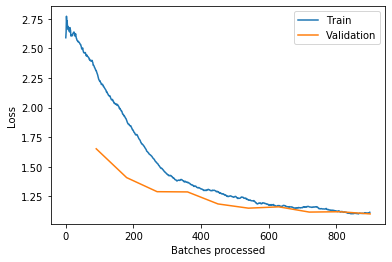

In [14]:
learn.fit_one_cycle(10) # train for 5 cycles
learn.save('./stage1') # save the result
learn.recorder.plot_losses()

In [14]:
learn = learn.load('./stage1')

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

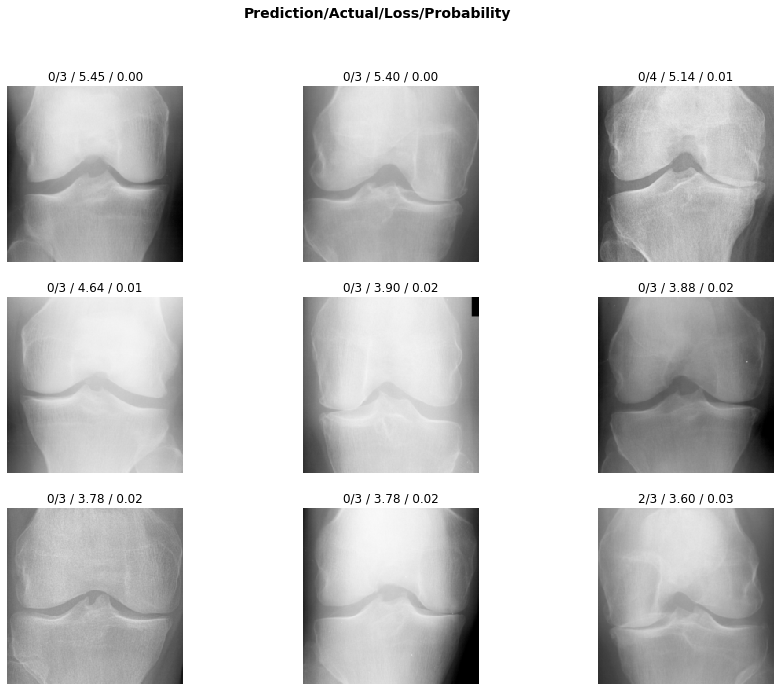

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
doc(interp.plot_top_losses)

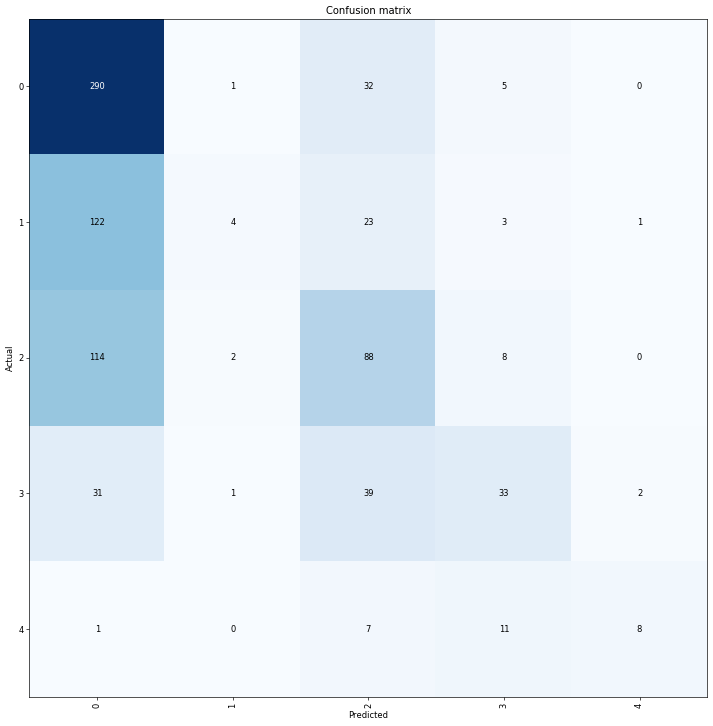

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

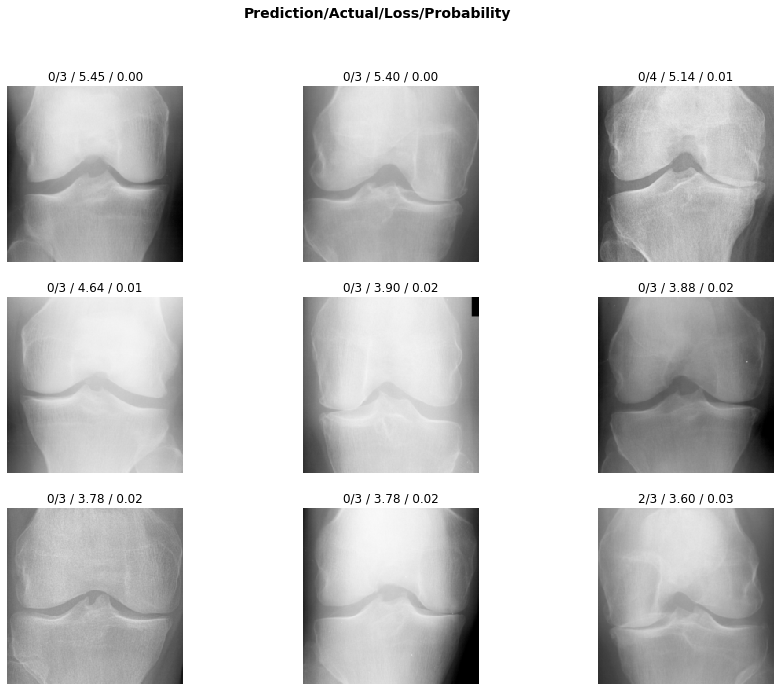

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

# 3. Fine-tune

In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [18]:
learn.recorder.plot()

AttributeError: 'Learner' object has no attribute 'lrs'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-2))
learn.save('./stage2')
learn.recorder.plot_losses()

In [ ]:
learn.load('./stage2')

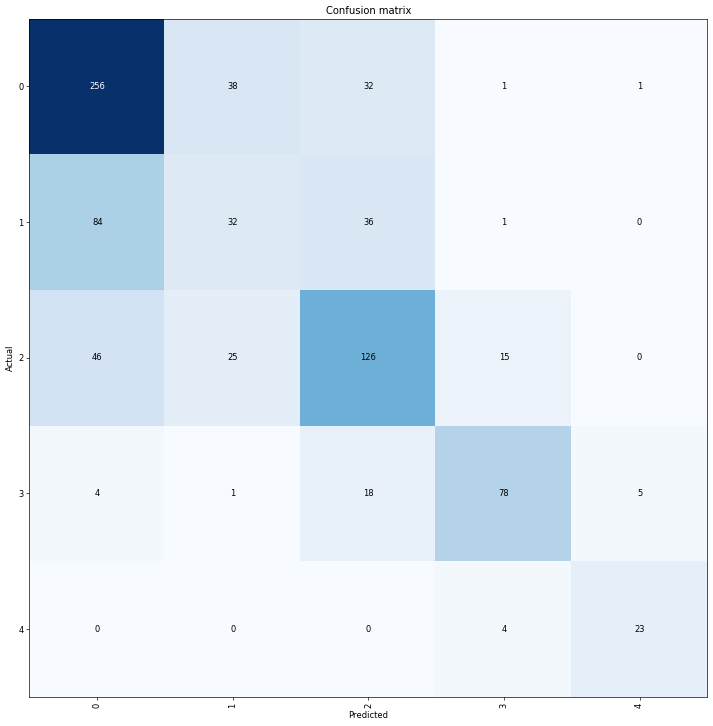

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

# 4. Visualizing the activations

Category 0

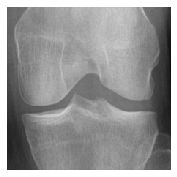

In [16]:
idx=200
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [26]:
from fastai.callbacks.hooks import *

In [27]:
m = learn.model.eval()
m[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [28]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
xb.shape
data.denorm(xb)[0].shape

torch.Size([3, 224, 224])

In [29]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [30]:
hook_a,hook_g = hooked_backward()

In [31]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 7, 7])

In [32]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [33]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

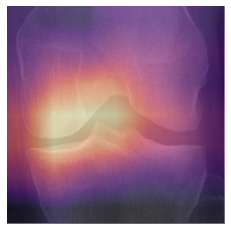

In [34]:
show_heatmap(avg_acts)

## Grad-CAM (optional)

In [36]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape
grad.shape

torch.Size([512, 7, 7])

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

In [38]:
hook_g.stored.shape

AttributeError: 'list' object has no attribute 'shape'